In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Understanding the dataset

In [160]:
data = pd.read_csv("train.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3000 non-null   object 
 1   account_length                 3000 non-null   int64  
 2   area_code                      3000 non-null   object 
 3   international_plan             3000 non-null   object 
 4   voice_mail_plan                3000 non-null   object 
 5   number_vmail_messages          3000 non-null   int64  
 6   total_day_minutes              3000 non-null   float64
 7   total_day_calls                3000 non-null   int64  
 8   total_day_charge               3000 non-null   float64
 9   total_eve_minutes              3000 non-null   float64
 10  total_eve_calls                3000 non-null   int64  
 11  total_eve_charge               3000 non-null   float64
 12  total_night_minutes            3000 non-null   f

### There are 5 categorical variables: state, area_code, international_plan, voice_mail_plan, payment_delay.

----------------------------------------
Class Distribution for state:
state
WV    3.366667
MN    2.766667
AL    2.566667
WY    2.566667
VA    2.533333
TX    2.400000
ID    2.400000
NY    2.366667
MI    2.366667
OH    2.266667
UT    2.233333
CT    2.166667
MA    2.133333
WI    2.133333
OR    2.133333
NJ    2.100000
MS    2.100000
OK    2.066667
MT    2.066667
VT    2.033333
ME    2.000000
NH    1.966667
AR    1.966667
NM    1.966667
IN    1.933333
IL    1.933333
FL    1.900000
RI    1.866667
CO    1.833333
AZ    1.833333
ND    1.800000
SC    1.800000
NC    1.800000
WA    1.800000
MD    1.766667
KS    1.766667
KY    1.733333
DE    1.733333
TN    1.733333
DC    1.700000
NE    1.700000
GA    1.666667
NV    1.633333
LA    1.600000
HI    1.566667
MO    1.566667
PA    1.466667
AK    1.466667
SD    1.433333
IA    1.433333
CA    0.866667
Name: proportion, dtype: float64
----------------------------------------


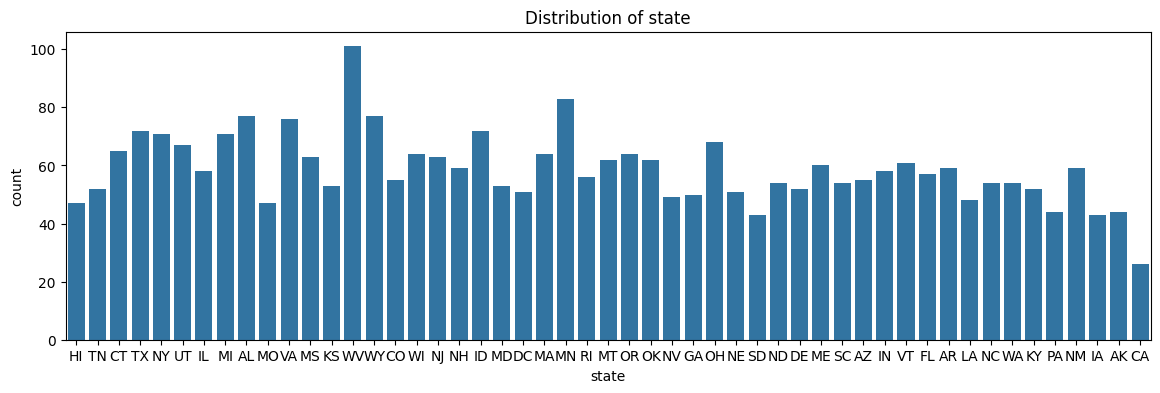

----------------------------------------
Class Distribution for area_code:
area_code
area_code_415    49.100000
area_code_510    25.666667
area_code_408    25.233333
Name: proportion, dtype: float64
----------------------------------------


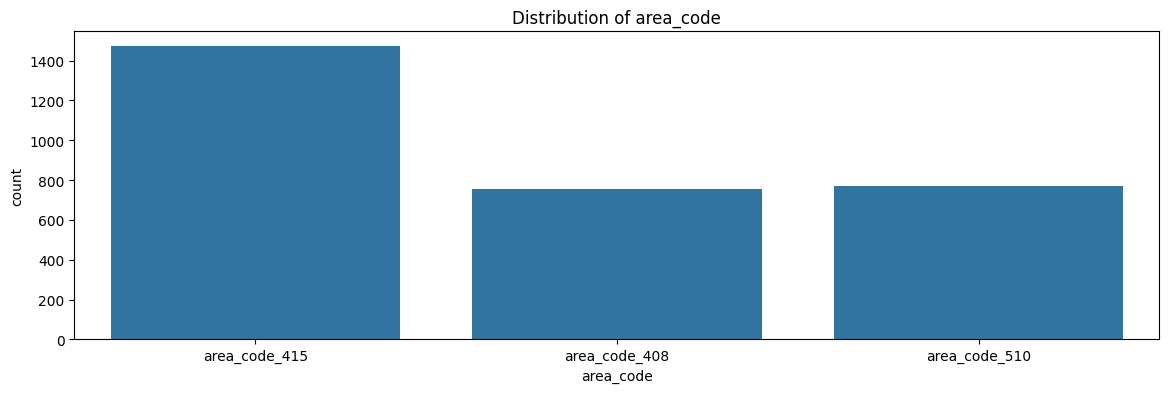

----------------------------------------
Class Distribution for international_plan:
international_plan
no     90.633333
yes     9.366667
Name: proportion, dtype: float64
----------------------------------------


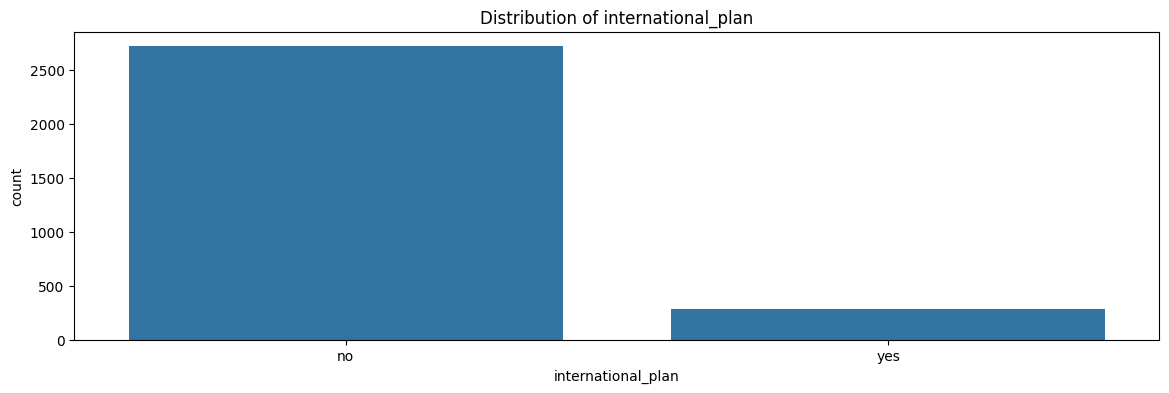

----------------------------------------
Class Distribution for voice_mail_plan:
voice_mail_plan
no     72.966667
yes    27.033333
Name: proportion, dtype: float64
----------------------------------------


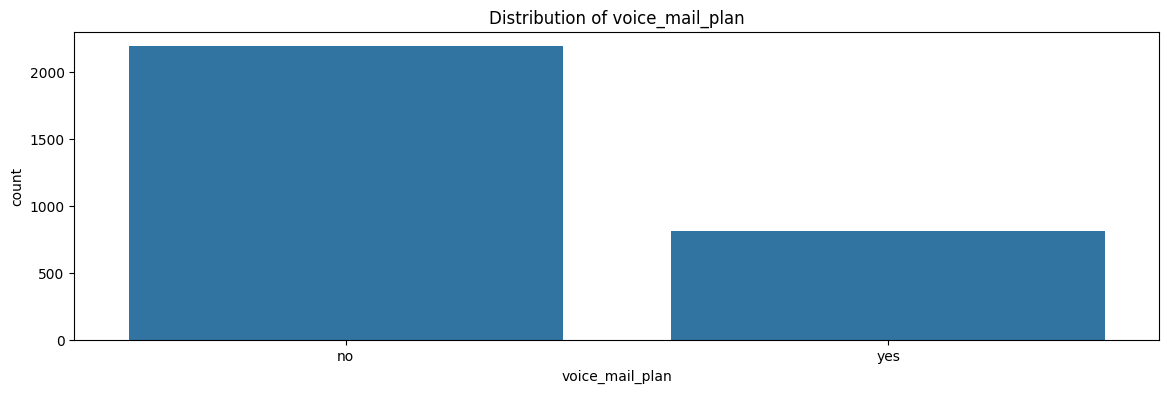

----------------------------------------
Class Distribution for payment_delay:
payment_delay
no     86.233333
yes    13.766667
Name: proportion, dtype: float64
----------------------------------------


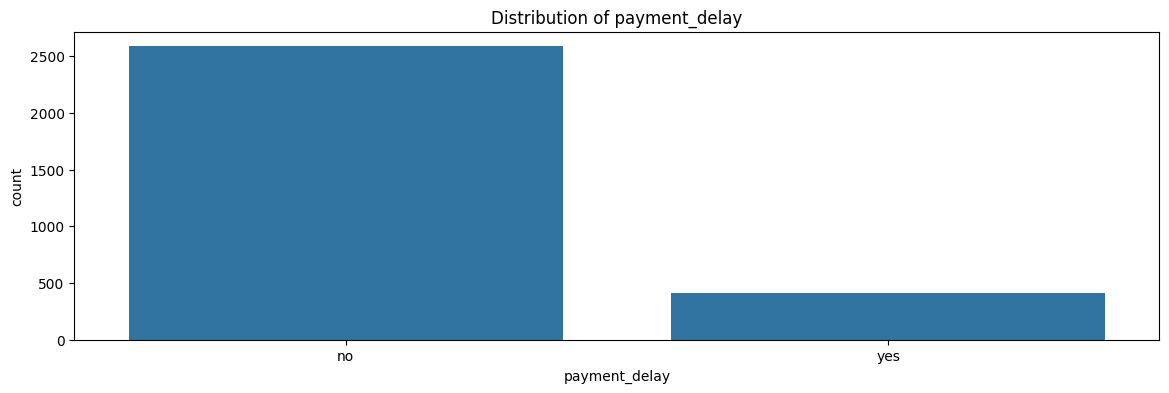

In [161]:
categorical_columns = ['state', 'area_code', 'international_plan', 'voice_mail_plan', 'payment_delay']
for col in categorical_columns:
    print("-" * 40)
    print(f"Class Distribution for {col}:")
    print(data[col].value_counts(normalize=True) * 100)
    print("-" * 40)

    plt.figure(figsize=(14, 4))
    sns.countplot(x=col, data=data)
    plt.title(f'Distribution of {col}')
    plt.show()

#### Most states have relatively balanced proportions, with California having the lowest proportion at approximately 0.87% and West Virginia the highest at 3.37%.

#### This can be also observed with the area_code distribution.

#### The majority of customers do not have an international or a voicemail plan and do not delay their payment. The distribution of classes is imbalanced.



       account_length  total_day_minutes  total_day_calls  total_day_charge  \
count     3000.000000        3000.000000      3000.000000       3000.000000   
mean       100.510000         180.456533       100.228667         30.678167   
std         39.485782          54.098371        19.763769          9.196706   
min          1.000000           0.000000         0.000000          0.000000   
25%         73.000000         143.700000        87.000000         24.430000   
50%        100.000000         179.400000       101.000000         30.500000   
75%        127.000000         216.800000       113.000000         36.860000   
max        233.000000         346.800000       165.000000         58.960000   

       total_eve_minutes  total_eve_calls  total_eve_charge  \
count        3000.000000      3000.000000       3000.000000   
mean          200.034000       100.247333         17.003100   
std            50.127406        19.761638          4.260769   
min            22.300000        12.0

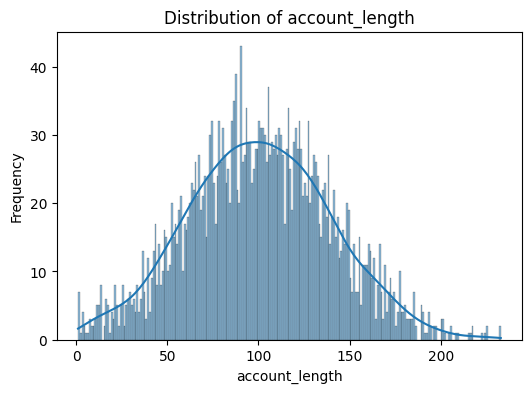

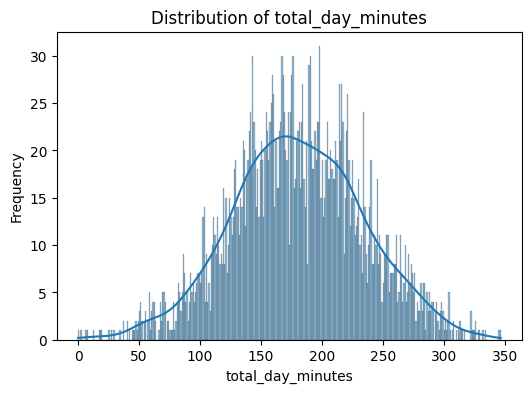

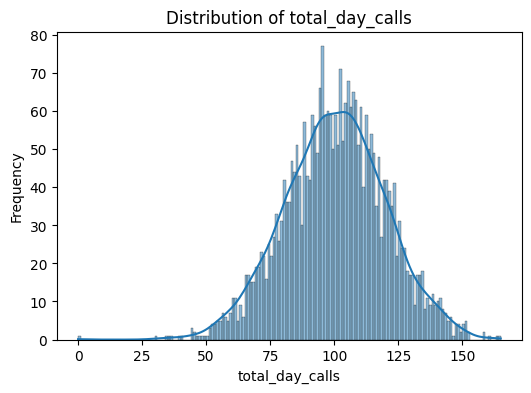

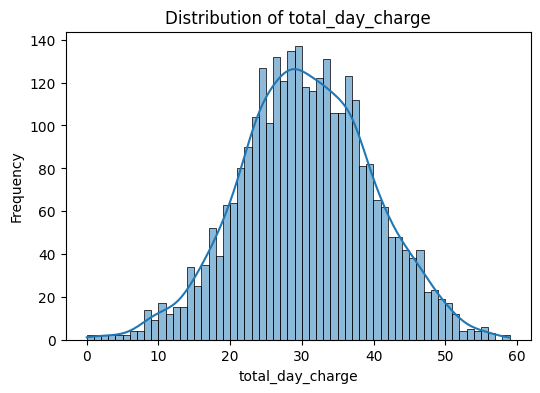

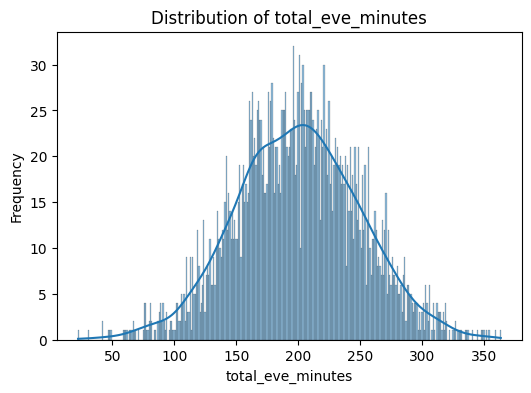

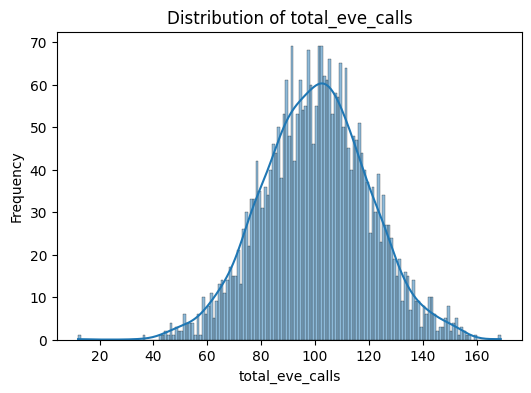

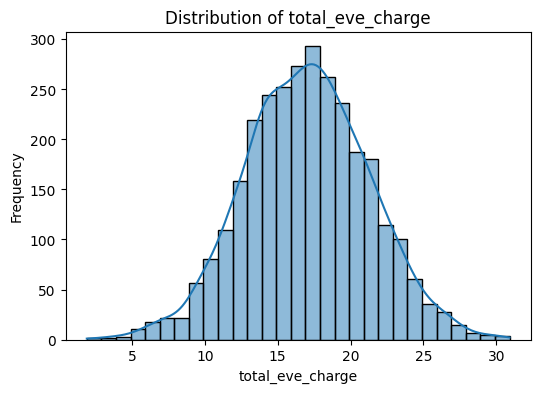

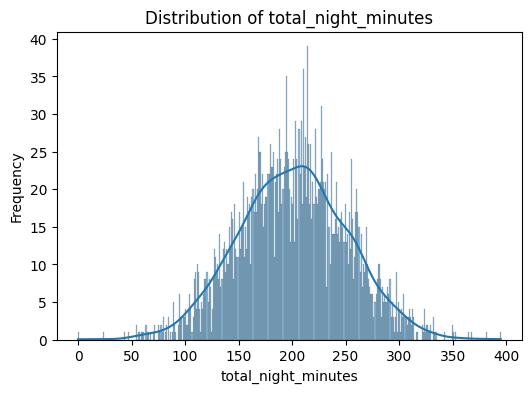

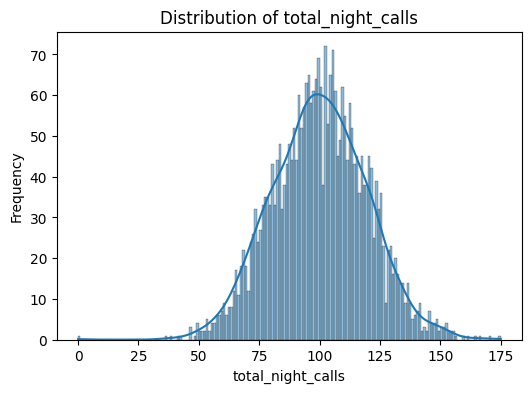

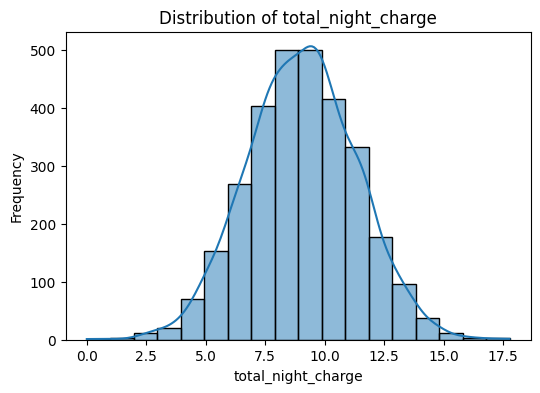

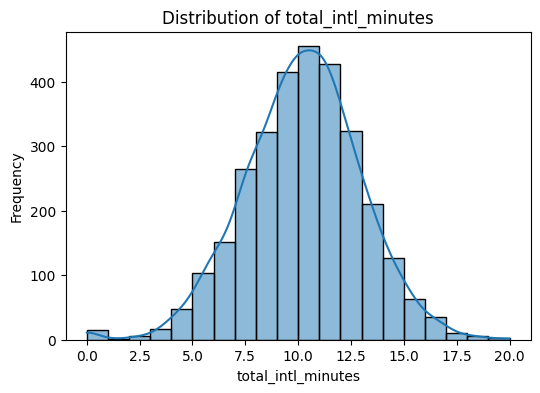

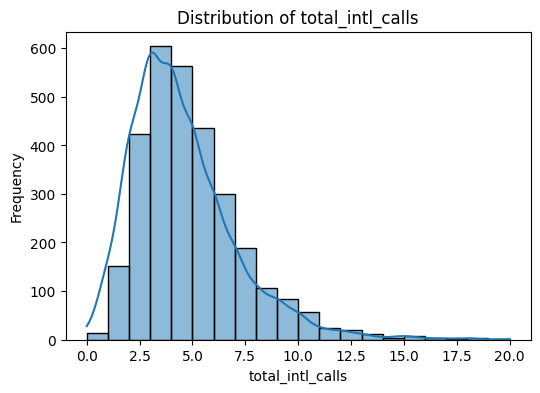

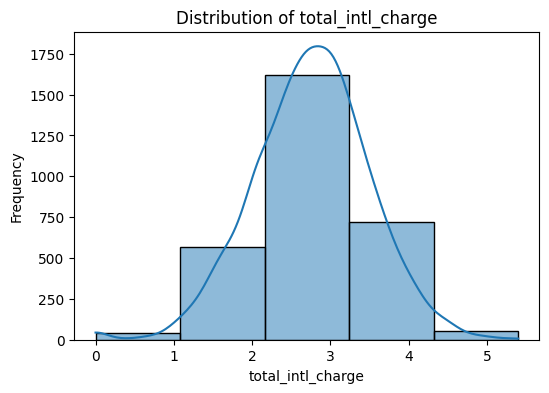

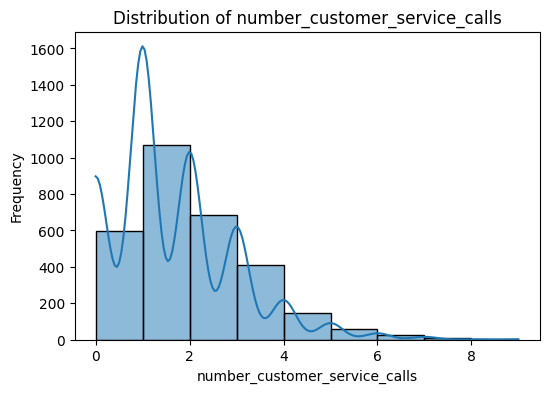

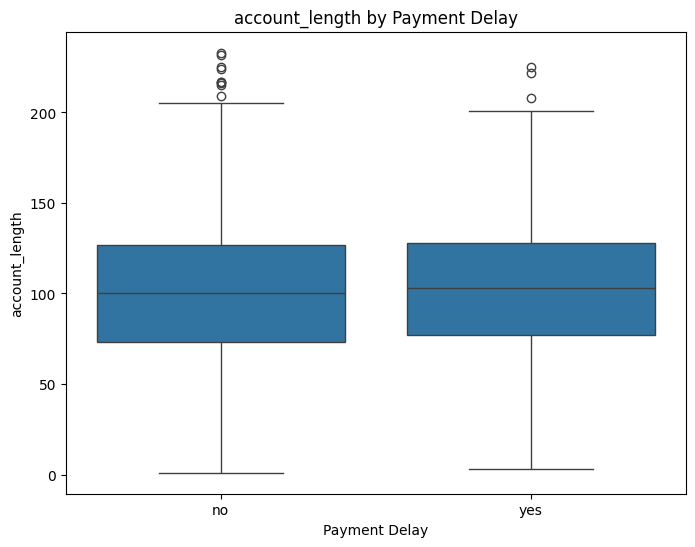

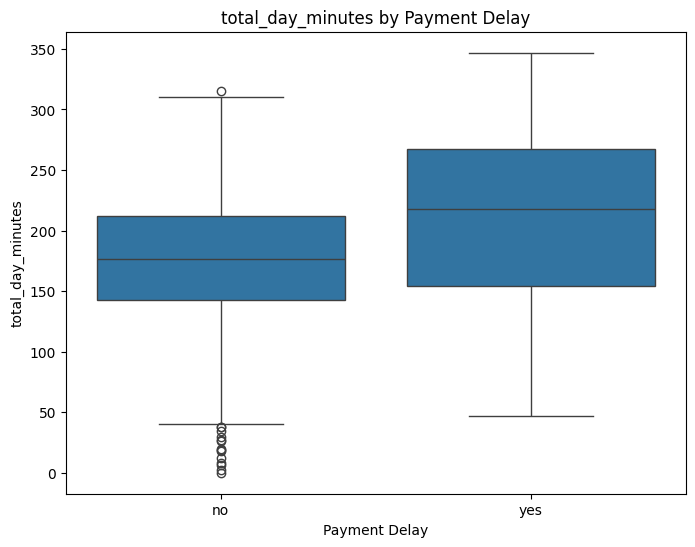

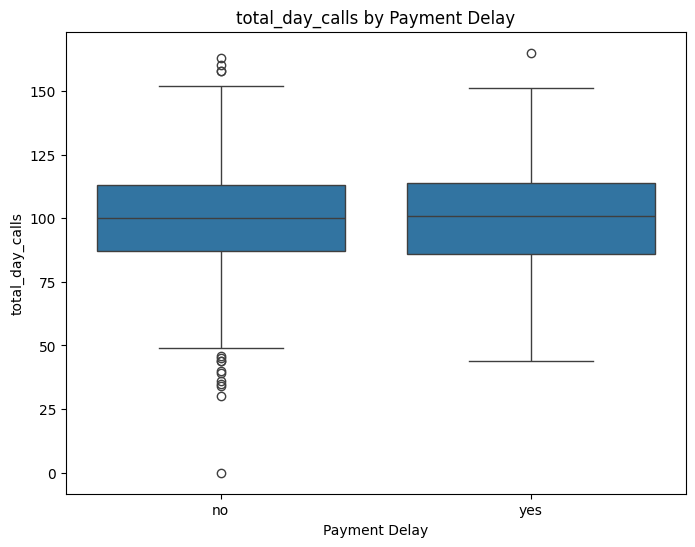

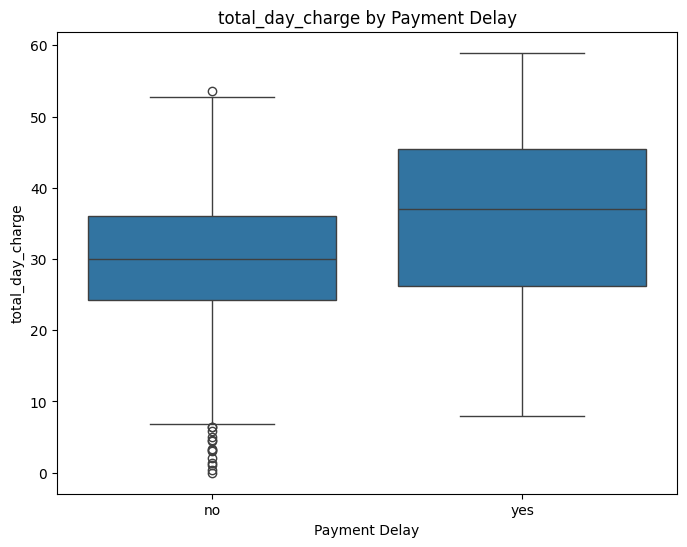

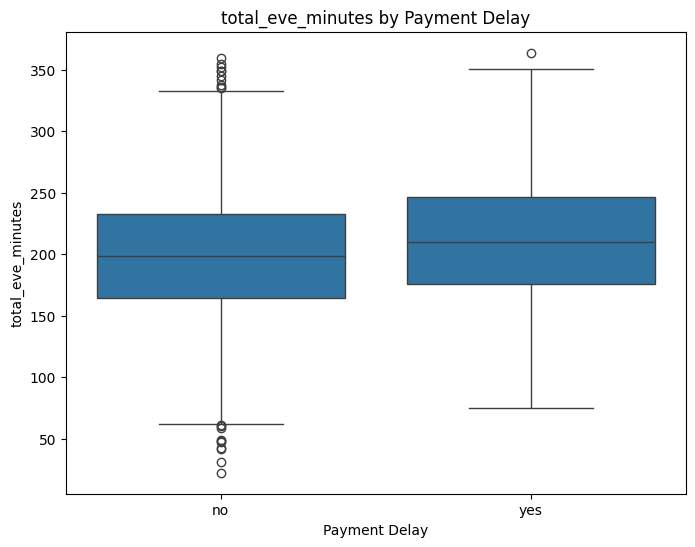

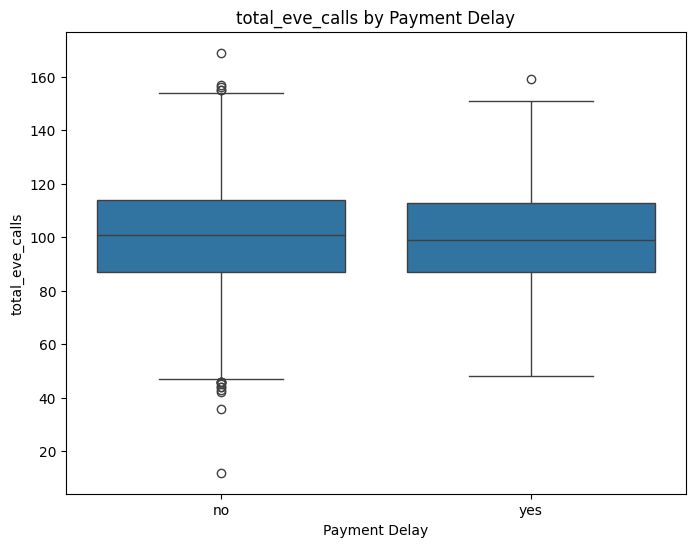

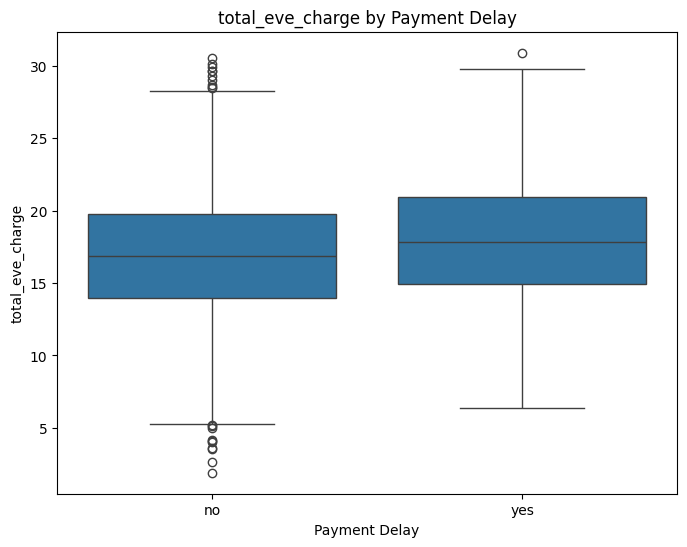

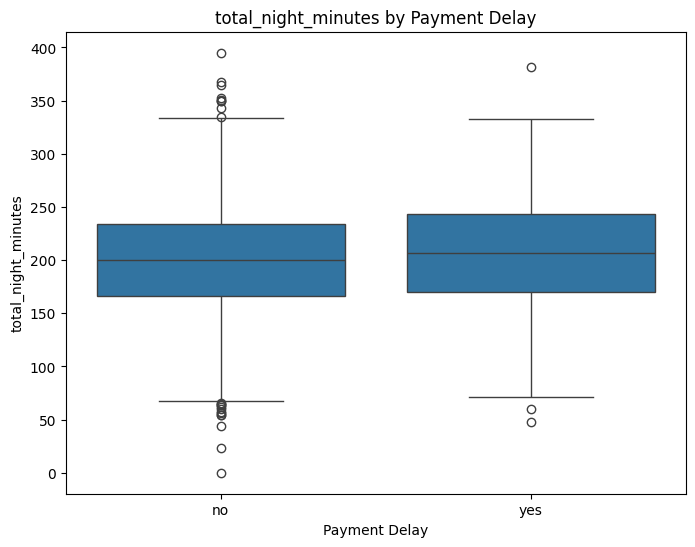

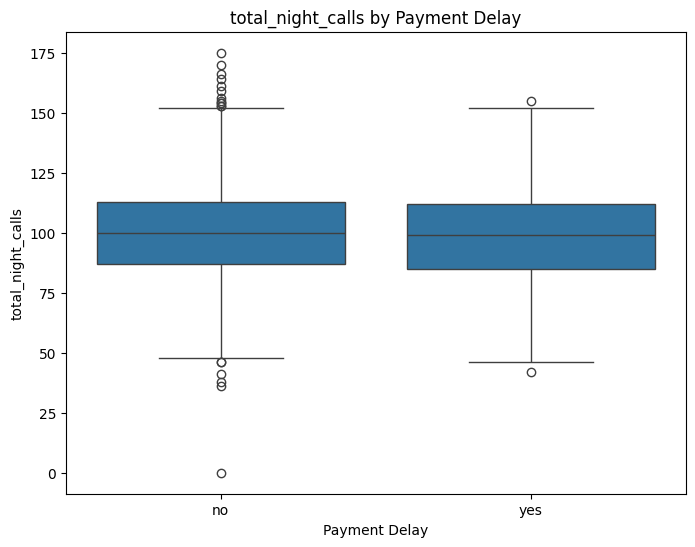

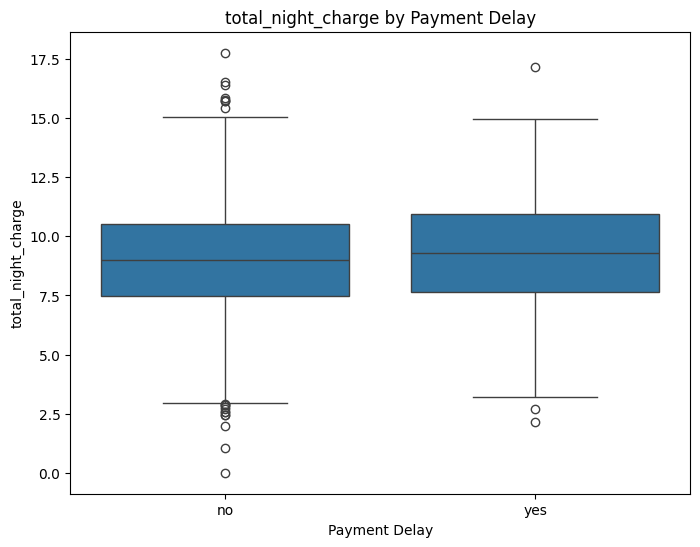

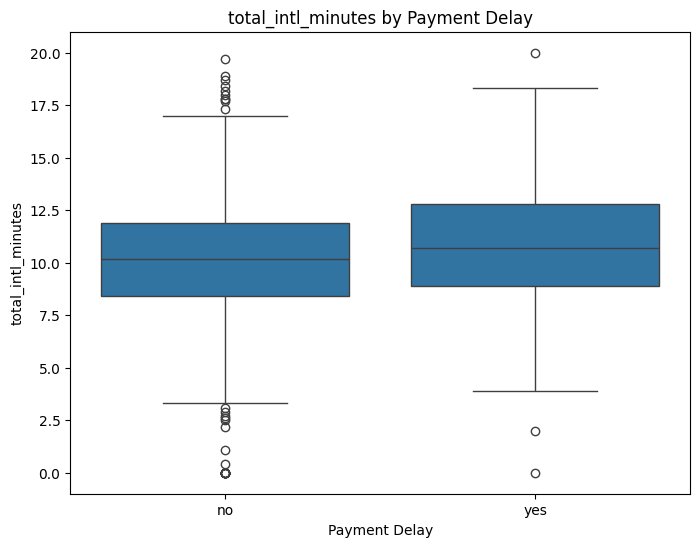

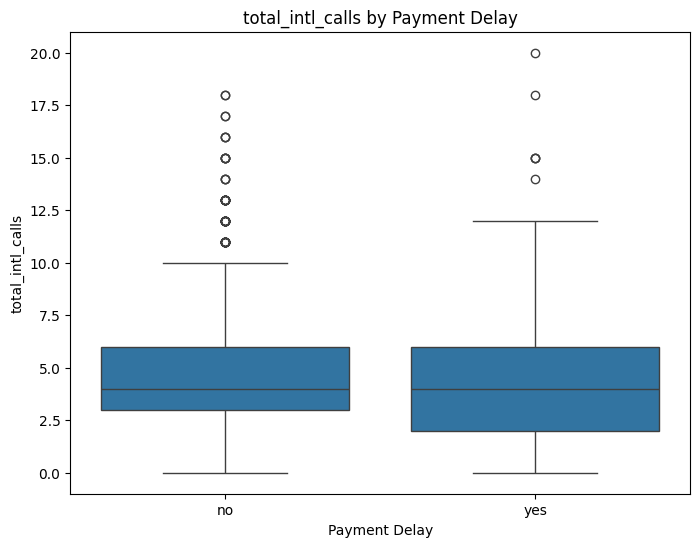

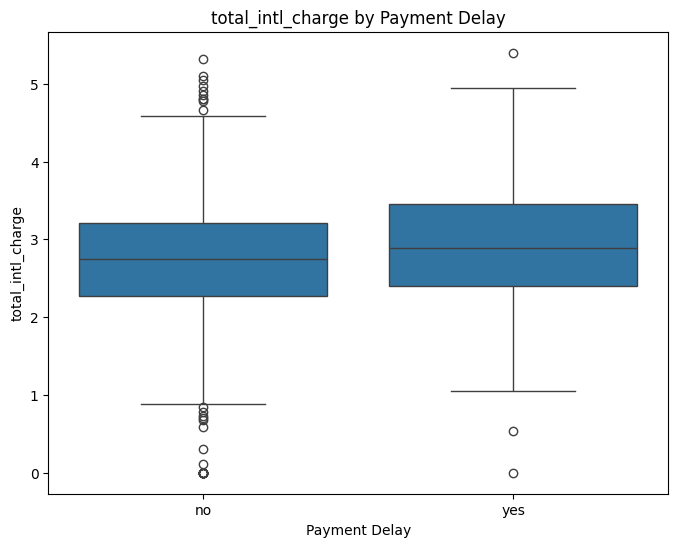

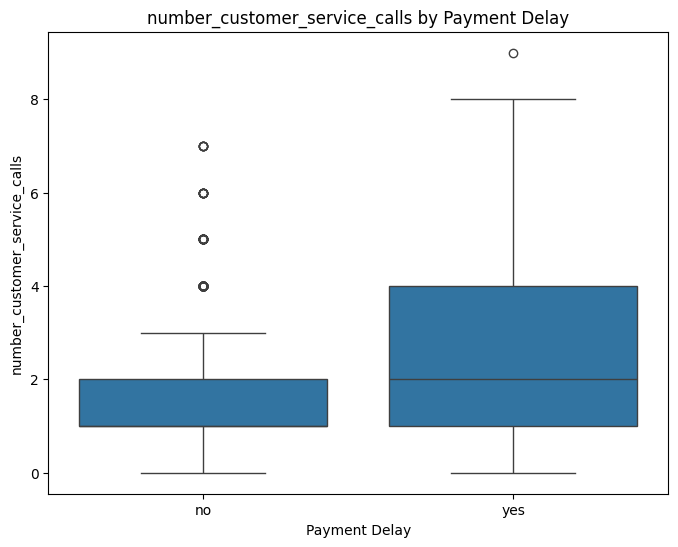

In [162]:
numerical_cols = ['account_length', 'total_day_minutes', 'total_day_calls', 'total_day_charge',
                  'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 
                  'total_night_minutes', 'total_night_calls', 'total_night_charge', 
                  'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 
                  'number_customer_service_calls']

print(data[numerical_cols].describe())

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True, binwidth=1)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for num_col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='payment_delay', y=num_col, data=data)
    plt.title(f'{num_col} by Payment Delay')
    plt.xlabel('Payment Delay')
    plt.ylabel(num_col)
    plt.show()



#### Most of the numerical classes seem to follow a normal distribution. The data seems to be dispersed well enough, and no further modifications are required.

In [163]:
label_encoder = LabelEncoder()
encoded_data = {}
for col in categorical_columns:
    label_encoder.fit(data[col])
    encoded_data[col] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print(f"Mapping for '{col}': {encoded_data[col]}")
    
    data[col] = label_encoder.transform(data[col])


Mapping for 'state': {'AK': 0, 'AL': 1, 'AR': 2, 'AZ': 3, 'CA': 4, 'CO': 5, 'CT': 6, 'DC': 7, 'DE': 8, 'FL': 9, 'GA': 10, 'HI': 11, 'IA': 12, 'ID': 13, 'IL': 14, 'IN': 15, 'KS': 16, 'KY': 17, 'LA': 18, 'MA': 19, 'MD': 20, 'ME': 21, 'MI': 22, 'MN': 23, 'MO': 24, 'MS': 25, 'MT': 26, 'NC': 27, 'ND': 28, 'NE': 29, 'NH': 30, 'NJ': 31, 'NM': 32, 'NV': 33, 'NY': 34, 'OH': 35, 'OK': 36, 'OR': 37, 'PA': 38, 'RI': 39, 'SC': 40, 'SD': 41, 'TN': 42, 'TX': 43, 'UT': 44, 'VA': 45, 'VT': 46, 'WA': 47, 'WI': 48, 'WV': 49, 'WY': 50}
Mapping for 'area_code': {'area_code_408': 0, 'area_code_415': 1, 'area_code_510': 2}
Mapping for 'international_plan': {'no': 0, 'yes': 1}
Mapping for 'voice_mail_plan': {'no': 0, 'yes': 1}
Mapping for 'payment_delay': {'no': 0, 'yes': 1}


### The categorical columns need to be encoded, in order to be visualised using the correlation matrix.

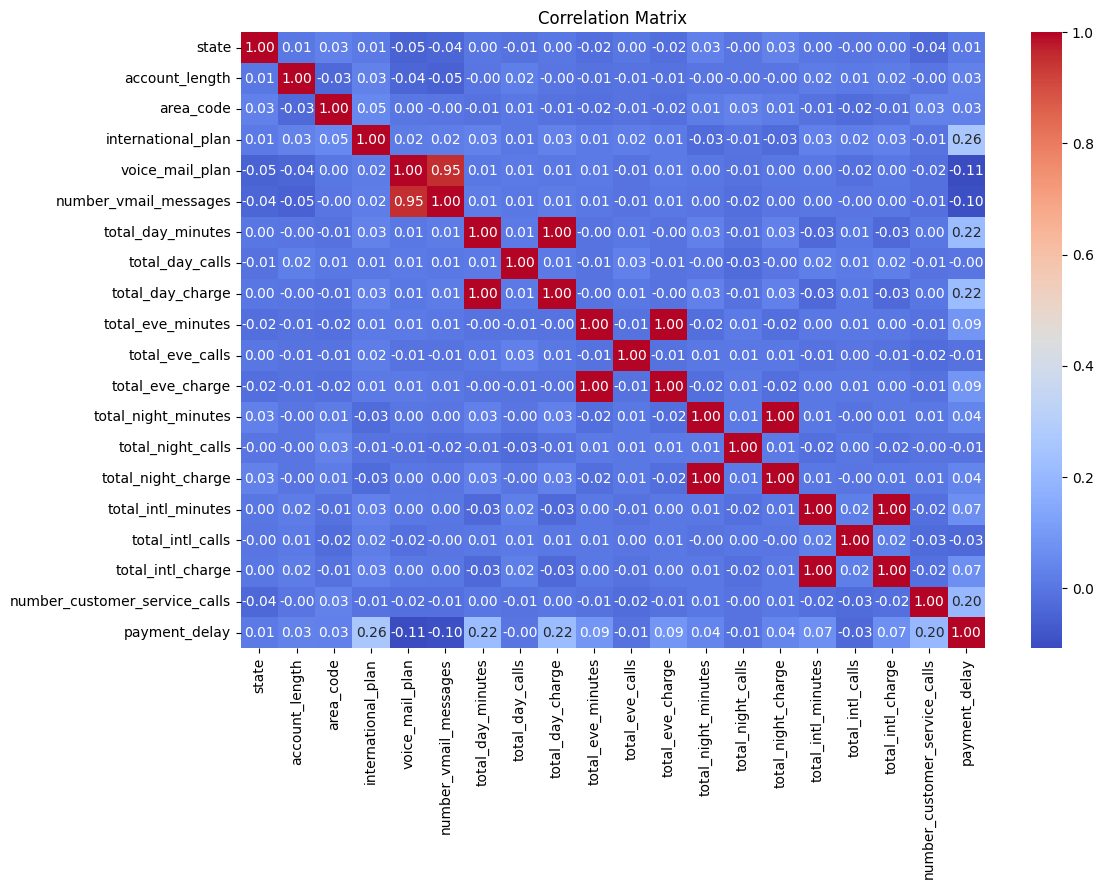

In [164]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Filtering the features that are redundant: 

In [165]:
high_correlation_threshold = 0.9
low_correlation_threshold = 0.05
high_correlation_features = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_correlation_threshold:
            col_name = correlation_matrix.columns[i]
            high_correlation_features.append(col_name)


target_correlation = correlation_matrix['payment_delay'].drop('payment_delay')
low_correlation_features = target_correlation[target_correlation.abs() < low_correlation_threshold].index

reduced_features = set(list(low_correlation_features) + high_correlation_features)
data_reduced = data.drop(columns=reduced_features, axis=1)

print(f"Low correlation features to drop: {list(low_correlation_features)}")
print(f"Highly correlated features to drop: {high_correlation_features}")
# print(f'reduced features: {reduced_features}')
print(f"Reduced Data Columns: {list(data_reduced.columns)}")


Low correlation features to drop: ['state', 'account_length', 'area_code', 'total_day_calls', 'total_eve_calls', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_calls']
Highly correlated features to drop: ['number_vmail_messages', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
Reduced Data Columns: ['international_plan', 'voice_mail_plan', 'total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'number_customer_service_calls', 'payment_delay']


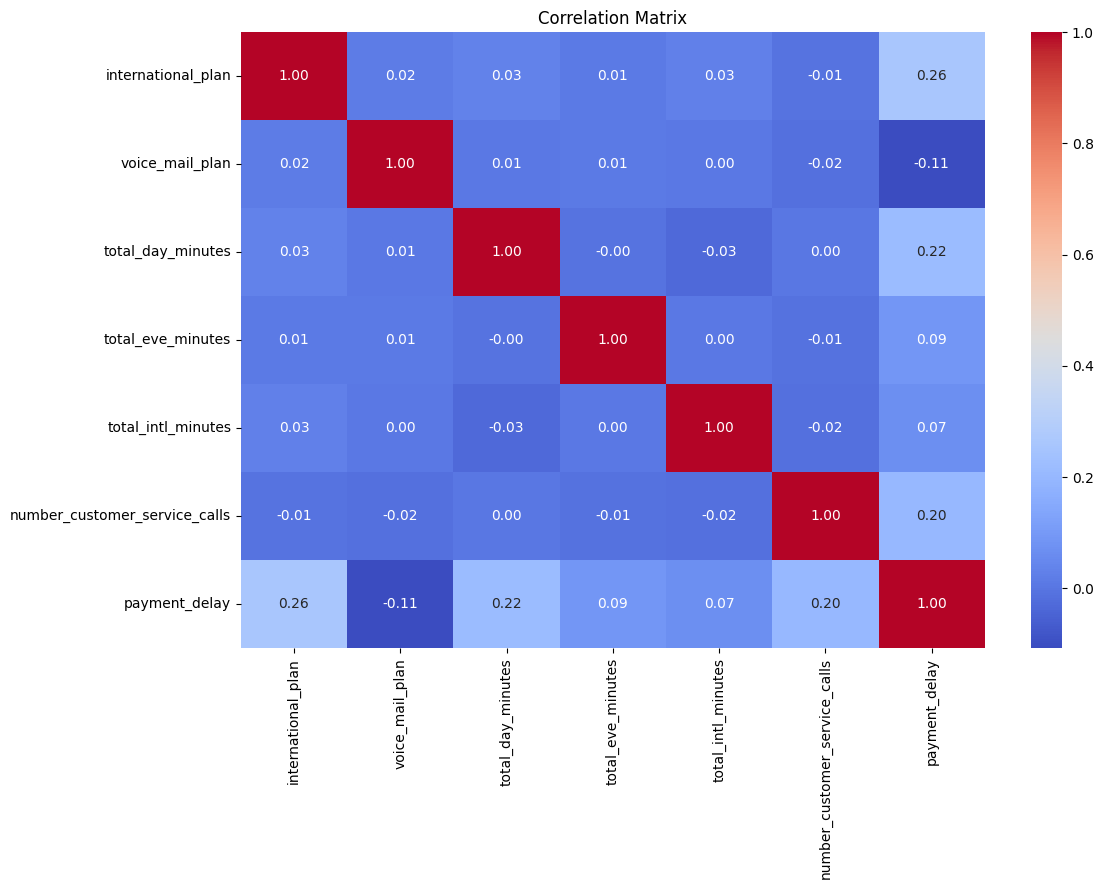

In [166]:
correlation_matrix = data_reduced.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### - Customers that spend a lot of minutes during the day, evening, or night on calls might churn due to high bills.

### - Suggestion: Offer loyalty discounts or customized plans.

### - Many customer service calls likely indicate unresolved issues.

### - Suggestion: Improve customer support and offer faster resolution.

### - International plans may lead to a payment delay for several reasons: complex billing structures, international payment complications, language barriers, lack of trust or perceived value.

### - Suggestions: Simplified billing, flexible payment options, effective customer communication

## Readying the dataset for training

In [167]:
test_size = 0.2
validation_size = 0.2
validation_relative_size = validation_size / (1 - test_size)

train_val_data, test_data = train_test_split(data_reduced, test_size=test_size)

train_data, validation_data = train_test_split(train_val_data, test_size=validation_relative_size)

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: (1800, 7)
Validation data shape: (600, 7)
Test data shape: (600, 7)


## Resampling

In [168]:
X_train = train_data.drop(columns='payment_delay')
y_train = train_data['payment_delay']
X_val = validation_data.drop(columns='payment_delay')
y_val = validation_data['payment_delay']
X_test = test_data.drop(columns='payment_delay')
y_test = test_data['payment_delay']

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("New class distribution after SMOTE:")
print(y_train_resampled.value_counts(normalize=True) * 100)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

New class distribution after SMOTE:
payment_delay
0    50.0
1    50.0
Name: proportion, dtype: float64


# Training the model

In [169]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "SVM Classifier": SVC(random_state=42, probability=True),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42),
    "KNN Classifier": KNeighborsClassifier()
}
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]


results = []
best_accuracy = 0

for model_name, model in models.items():
    print(f"Training {model_name}...")
    if "SVM" in model_name or "Logistic Regression" in model_name:  
        model.fit(X_train_scaled, y_train_resampled)
        y_val_pred = model.predict(X_val_scaled)
        y_test_pred = model.predict(X_test_scaled)
    else:  
        model.fit(X_train_resampled, y_train_resampled)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val_scaled)[:, 1]) if hasattr(model, "predict_proba") else None
    
    results.append({
        "Model": model_name,
        "Accuracy": val_accuracy,
        "Precision": val_precision,
        "Recall": val_recall,
        "F1-score": val_f1,
        "ROC-AUC": val_roc_auc
    })

    if val_accuracy > best_accuracy:
        print("New model is better, saving it.")
        joblib.dump(model, 'best_model.pkl')
        best_accuracy = val_accuracy
    else:
        print("Current model is not better, keeping the old one.")

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

results_df.to_csv("model_comparison_results.csv", index=False)

Training Logistic Regression...
New model is better, saving it.
Training Decision Tree Classifier...
New model is better, saving it.
Training Random Forest Classifier...


/home/macron/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/macron/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


New model is better, saving it.
Training SVM Classifier...
Current model is not better, keeping the old one.
Training Gradient Boosting Classifier...
Current model is not better, keeping the old one.
Training KNN Classifier...
Current model is not better, keeping the old one.

Model Performance Comparison:
                          Model  Accuracy  Precision    Recall  F1-score  \
0           Logistic Regression  0.678333   0.884862  0.678333  0.741029   
1      Decision Tree Classifier  0.825000   0.905119  0.825000  0.851776   
2      Random Forest Classifier  0.890000   0.922900  0.890000  0.901291   
3                SVM Classifier  0.840000   0.910118  0.840000  0.863299   
4  Gradient Boosting Classifier  0.880000   0.918048  0.880000  0.893156   
5                KNN Classifier  0.716667   0.857415  0.716667  0.767736   

    ROC-AUC  
0  0.798177  
1  0.522964  
2  0.688842  
3  0.888536  
4  0.725926  
5  0.500000  


/home/macron/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/macron/.local/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
